##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

## Setup

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
np.set_printoptions(precision = 3, suppress = True)

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
def plot_graphs(hist, metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

## Setup input pipeline

[3865, 68, 1089, 3340, 514] 8876


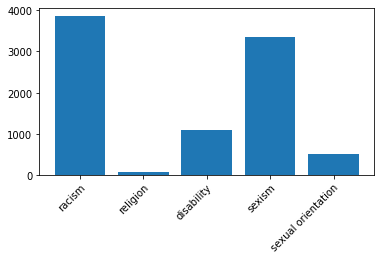

<Figure size 1152x432 with 0 Axes>

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class_count = 6
classes = ['other', 'racism', 'religion', 'disability', 'sexism', 'sexual orientation', 'toxic', 'obscene']


#
# Load the csv data.
#
def load_data_arrays():
    df_1 = pd.read_csv("datasets/1_preprocessed.csv")
    df_3 = pd.read_csv("datasets/3_preprocessed.csv")

    df_5 = pd.read_csv("datasets/5_preprocessed.csv")

    df_6 = pd.read_csv("datasets/6_preprocessed.csv")

    df = df_1.append(df_3)
    df = df.append(df_6)
    df = df.append(df_5)
    # Remove everything that isn't offensive/hate-speech
    df = df[(df['is_hatespeech'] == 1)]
    # Remove classes that use up a lot of probability mass.
    df = df[(df['class'] != 0)]
    df = df[(df['class'] != 6)]
    df = df[(df['class'] != 7)]

    return train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = df["class"])


def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    counts = [total.count(bin_val) for bin_val in bins]
    print(counts, sum(counts))
    plt.xticks(bins,
               classes[1:6],
               rotation = 45,
               rotation_mode = "anchor",
               ha = "right")

    plt.subplots_adjust(bottom = 0.3)
    plt.figure(figsize = (16, 6))
    plt.show()


train_df, test_df = load_data_arrays()

plot_data_distribution(train_df['class'].values, test_df['class'].values)

In [5]:
#
# Convert the test- and train-DataFrames to Tensorflow Datasets
#
train_labels = np.eye(class_count)[train_df['class'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype = str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(class_count)[test_df['class'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype = str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

print(test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(6,), dtype=tf.int32, name=None))


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'a', 'you', 'the', 'is', 'i', 'nigger', 'to', 'and',
       'of', 'fat', 'jew', 'in', 'are', 'not', 'that', 'but', 'faggot',
       'me'], dtype='<U30')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [9]:
encoded_example = encoder("a")[:1].numpy()
encoded_example

array([2], dtype=int64)

## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    tf.keras.layers.Dense(class_count, activation = 'softmax')
])

print(model.summary())

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.00075),
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 138,694
Trainable params: 138,694
Non-trai

## Train the model

In [11]:
history = model.fit(train_dataset, epochs = 5,
                    validation_data = test_dataset,
                    validation_steps = 5)

Epoch 1/5
111/111 [==============================] - 14s 73ms/step - loss: 1.3446 - accuracy: 0.3892 - val_loss: 1.1442 - val_accuracy: 0.6125
Epoch 2/5
111/111 [==============================] - 6s 56ms/step - loss: 0.8367 - accuracy: 0.7139 - val_loss: 0.6109 - val_accuracy: 0.7906
Epoch 3/5
111/111 [==============================] - 6s 54ms/step - loss: 0.5256 - accuracy: 0.8234 - val_loss: 0.5383 - val_accuracy: 0.8188
Epoch 4/5
111/111 [==============================] - 6s 54ms/step - loss: 0.4455 - accuracy: 0.8486 - val_loss: 0.5152 - val_accuracy: 0.8000
Epoch 5/5
111/111 [==============================] - 6s 54ms/step - loss: 0.3949 - accuracy: 0.8683 - val_loss: 0.5069 - val_accuracy: 0.8313


In [12]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

28/28 [==============================] - 1s 24ms/step - loss: 0.5088 - accuracy: 0.8401
Test Loss: 0.5087643265724182
Test Accuracy: 0.8400900959968567


In [13]:
# Save the model
#!mkdir models
#model.save('rnn_one', save_format='tf')

(0.0, 1.3921067431569099)

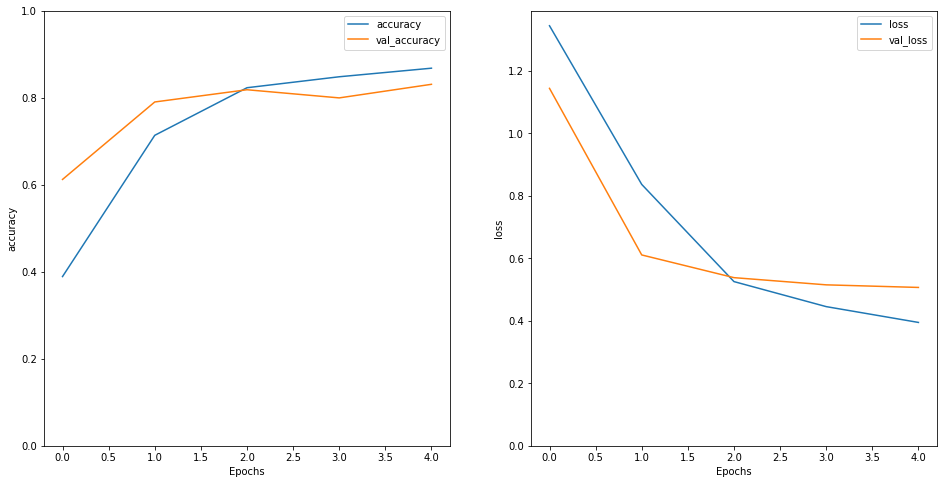

In [14]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)